In [1]:
from ase import Atoms
from ase.calculators.lammpslib import LAMMPSlib
from ase.lattice.hexagonal import Graphene
from ase import units

from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation, )

from ase.md.langevin import Langevin
from ase.md.md import MolecularDynamics
from ase.io.trajectory import Trajectory

from abtem import show_atoms
import numpy as np
import scipy.linalg as linalg

import matplotlib.pyplot as plt
from utils import load_gle_matrices
from ase.build import molecule
from ase.optimize import FIRE

from autocorrelation import autocorrelation

In [56]:
class VelocityVerlet(MolecularDynamics):
    def __init__(self, atoms, timestep=None, trajectory=None, logfile=None,
                 loginterval=1, dt=None, append_trajectory=False):

        if dt is not None:
            warnings.warn(FutureWarning('dt variable is deprecated; please use timestep.'))
            timestep = dt
        if timestep is None:
            raise TypeError('Missing timestep argument')

        MolecularDynamics.__init__(self, atoms, timestep, trajectory, logfile, loginterval,
                                   append_trajectory=append_trajectory)

    def step(self):

        atoms = self.atoms
        forces = atoms.get_forces()
        masses = atoms.get_masses()[:, np.newaxis]
        r = atoms.get_positions()
        
        p = atoms.get_momenta() + 0.5 * self.dt * forces
        
        atoms.set_positions(r + self.dt * p / masses)
                
        atoms.set_momenta(p, apply_constraint=False)

        forces = atoms.get_forces(md=True)
        
        atoms.set_momenta(atoms.get_momenta() + 0.5 * self.dt * forces)
        
        return forces


    
unit_conversions = {
    "atomic time units^-1": 1 / units.fs * 1e-15 / units._aut,
    "picoseconds^-1": 1 / 1000 / units.fs,
    "seconds^-1": 1 / units.fs * 1e-15,
    "femtoseconds^-1": units._aut / 1e-15,
    "eV": 1,
    "atomic energy units": units.Ha,
    "K": units.kB,
}


def read_gle4md_file(filename, start, stop=None):
    read = False

    matrix = []
    with open(filename) as glefile:
        for line in glefile:
            if read:
                if stop:
                    if stop in line:
                        break
                
                matrix += [[float(x) for x in line.split()]]

            if start in line:
                read = True
                unit_name = line.strip().split("(")[-1].replace(")", "")
        
    return np.array(matrix) * unit_conversions[unit_name]
    
class GLEThermostat(MolecularDynamics):
    
    def __init__(self, atoms, timestep, A=None, C=None, gle4md_file=None, trajectory=None, logfile=None,
                 loginterval=1, append_trajectory=False):
        
        if gle4md_file is not None:
            if (A is not None) or (C is not None):
                raise ValueError()
            
            A = read_gle4md_file(gle4md_file, start='# A MATRIX:', stop='# C MATRIX:')
            C = read_gle4md_file(gle4md_file, start='# C MATRIX:')
        
        self.T = linalg.expm(-0.5 * timestep * A)
        self.S = linalg.sqrtm(C - np.dot(self.T, np.dot(C, self.T.T)))
        
        self.thermostat_factor = np.sqrt(atoms.get_masses())[..., None, None]
        self.thermostat_momenta = np.random.randn(*atoms.get_momenta().shape, self.S.shape[-1])
        self.thermostat_momenta = np.dot(self.thermostat_momenta, self.S)  
        
        MolecularDynamics.__init__(self, atoms, timestep, trajectory, logfile, loginterval,
                                   append_trajectory=append_trajectory)
    
    @classmethod
    def from_gle4md_file(cls, atoms, timestep, gle4md_file, trajectory=None, logfile=None, loginterval=1, 
                         append_trajectory=False):
        A = read_gle4md_file(gle4md_file, start='# A MATRIX:', stop='# C MATRIX:')
        C = read_gle4md_file(gle4md_file, start='# C MATRIX:')
        return cls(atoms, A=A, C=C, timestep=timestep, trajectory=trajectory, logfile=logfile,
                             loginterval=loginterval, append_trajectory=append_trajectory)
        
    def _apply_thermostat(self, p):
        self.thermostat_momenta[:, :, 0] = p
        
        thermostat_noise = np.random.randn(*self.thermostat_momenta.shape)

        self.thermostat_momenta = (np.dot(self.thermostat_momenta, self.T) 
                                    + np.dot(thermostat_noise, self.S) * self.thermostat_factor)
        
        return self.thermostat_momenta[:, :, 0]
        
    def step(self):
        atoms = self.atoms

        p = self._apply_thermostat(atoms.get_momenta())
        p = p + 0.5 * self.dt * atoms.get_forces()
        
        atoms.set_positions(atoms.get_positions() + self.dt * p / atoms.get_masses()[:, None])                
        atoms.set_momenta(p)

        forces = atoms.get_forces(md=True)
        
        p = atoms.get_momenta() + 0.5 * self.dt * forces
        atoms.set_momenta(self._apply_thermostat(p))
        
        return forces


class DeltaThermostat(GLEThermostat):
    
    def __init__(self, atoms, timestep, temperature, peak_frequency, trajectory=None, logfile=None,
                 loginterval=1, append_trajectory=False):
        
        gle4md_file = 'delta_thermo_10THz_300K.txt'
        A = read_gle4md_file(gle4md_file, start='# A MATRIX:', stop='# C MATRIX:')
        C = read_gle4md_file(gle4md_file, start='# C MATRIX:')
        A = A / 10 * peak_frequency
        C = C / 300 * temperature
        
        super().__init__(atoms, A=A, C=C, timestep=timestep, trajectory=trajectory, logfile=logfile,
                             loginterval=loginterval, append_trajectory=append_trajectory)
    
        
        

In [45]:
#atoms = molecule('CH3')
#atoms.center(vacuum=10)
#atoms.cell

atoms = Atoms(Graphene(symbol='C', latticeconstant={'a':2.46, 'c': 12}))

atoms *= (1,2,1)
atoms.cell[1,0]=0

atoms *= (12,7,1)
atoms.wrap()

atoms.cell

Cell([29.52, 29.825914906336067, 12.0])

In [53]:
dyn = DeltaThermostat(atoms, timestep, 300, 47, trajectory='graphene.traj', loginterval=loginterval)


[[ 1.16441422e-02  1.63660913e-02 -1.52053642e-02  7.83664929e-03
  -1.10419087e-01]
 [-1.61441967e-02  1.41068751e-05  2.96138466e+00 -5.14774004e-01
   2.18652728e-01]
 [ 1.52053112e-02 -2.96138466e+00  6.15240086e-11 -5.83865411e-03
   4.30241675e-02]
 [-2.38729242e-03  5.14774004e-01  5.83865411e-03  3.02629609e-01
   4.43919338e-01]
 [-2.78595056e-01 -2.18652728e-01 -4.30241675e-02 -4.43919338e-01
   8.07169350e+00]] [[ 2.70900200e-06 -2.93990626e-04 -2.30894908e-04  4.53571680e-05
  -8.27433104e-06]
 [-2.93990626e-04  5.25003259e-02 -2.24530515e-04 -8.24402914e-04
   1.30215836e-03]
 [-2.30894908e-04 -2.24530515e-04  5.07834078e-02 -8.94229016e-03
   1.93900468e-04]
 [ 4.53571680e-05 -8.24402914e-04 -8.94229016e-03  1.66297821e-03
  -5.97825053e-05]
 [-8.27433104e-06  1.30215836e-03  1.93900468e-04 -5.97825053e-05
   3.92933871e-05]]


In [57]:
dyn = DeltaThermostat(atoms, timestep, 400, 47, trajectory='graphene.traj', loginterval=loginterval)


[[ 1.16441422e-02  1.63660913e-02 -1.52053642e-02  7.83664929e-03
  -1.10419087e-01]
 [-1.61441967e-02  1.41068751e-05  2.96138466e+00 -5.14774004e-01
   2.18652728e-01]
 [ 1.52053112e-02 -2.96138466e+00  6.15240086e-11 -5.83865411e-03
   4.30241675e-02]
 [-2.38729242e-03  5.14774004e-01  5.83865411e-03  3.02629609e-01
   4.43919338e-01]
 [-2.78595056e-01 -2.18652728e-01 -4.30241675e-02 -4.43919338e-01
   8.07169350e+00]] [[ 2.70900200e-06 -2.93990626e-04 -2.30894908e-04  4.53571680e-05
  -8.27433104e-06]
 [-2.93990626e-04  5.25003259e-02 -2.24530515e-04 -8.24402914e-04
   1.30215836e-03]
 [-2.30894908e-04 -2.24530515e-04  5.07834078e-02 -8.94229016e-03
   1.93900468e-04]
 [ 4.53571680e-05 -8.24402914e-04 -8.94229016e-03  1.66297821e-03
  -5.97825053e-05]
 [-8.27433104e-06  1.30215836e-03  1.93900468e-04 -5.97825053e-05
   3.92933871e-05]]


In [28]:
cmds = ['pair_style airebo 3.0',
        'pair_coeff * * CH.airebo C']

lammps = LAMMPSlib(lmpcmds=cmds, log_file=None, keep_alive=True)

atoms.set_calculator(lammps)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(f'Energy per atom: Epot = {epot:.3f} eV  Ekin = {ekin:.3f} eV (T = {ekin / (1.5 * units.kB):.3f} K) '
          f'Etot = {epot + ekin:.3f}eV')

In [29]:
loginterval = 1
timestep = .5 * units.fs

MaxwellBoltzmannDistribution(atoms, 0. * units.kB)
Stationary(atoms)
ZeroRotation(atoms)

#dyn = VelocityVerlet(atoms, timestep, trajectory='graphene.traj', loginterval=loginterval)
#dyn = Langevin(atoms, timestep, temperature=300 * units.kB, friction=1e-3, 
#               trajectory='graphene.traj', loginterval=loginterval)

#dyn = GLEThermostat(atoms, A, C, timestep=timestep, trajectory='graphene.traj', loginterval=loginterval)

opt = FIRE(atoms)
opt.run(.05)

dyn = DeltaThermostat(atoms, timestep, 300, 47, trajectory='graphene.traj', loginterval=loginterval)

#dyn = GLEThermostat.from_gle4md_file(atoms, timestep, 'gle_matrices.txt', 
#                                     trajectory='graphene.traj', loginterval=loginterval)

#dyn = GLEThermostat(atoms, 'gle_matrices.txt', timestep=timestep, trajectory='graphene.traj', loginterval=loginterval)
#dyn = VelocityVerlet(atoms, timestep=timestep, trajectory='graphene.traj', loginterval=1)


dyn.attach(printenergy, interval=1000)

# Now run the dynamics for 10000 timesteps.
dyn.run(70000)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 12:50:27    -2489.127655*       0.0000
Energy per atom: Epot = -7.408 eV  Ekin = 0.000 eV (T = 0.000 K) Etot = -7.408eV
Energy per atom: Epot = -7.408 eV  Ekin = 0.000 eV (T = 1.578 K) Etot = -7.408eV
Energy per atom: Epot = -7.408 eV  Ekin = 0.001 eV (T = 4.407 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 6.095 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 5.203 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 5.559 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 5.618 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 6.537 K) Etot = -7.407eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 5.627 K) Etot = -7.406eV
Energy per atom: Epot = -7.407 eV  Ekin = 0.001 eV (T = 6.284 K) Etot = -7.406eV
Energy per atom: Epot = -7.407 eV  Ekin = 

True

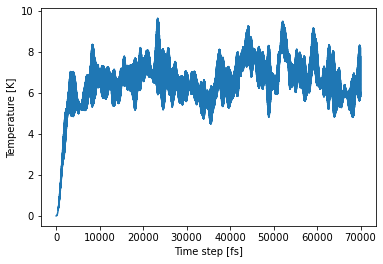

In [30]:
traj = Trajectory('graphene.traj', 'r')

time_step = np.linspace(0,(len(traj)-1)*loginterval*timestep,len(traj))
energies = [atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms)) for atoms in traj]

plt.plot(energies)
plt.xlabel('Time step [fs]')
plt.ylabel('Temperature [K]');

In [31]:
velocities = np.array([atoms.get_velocities() for atoms in traj])

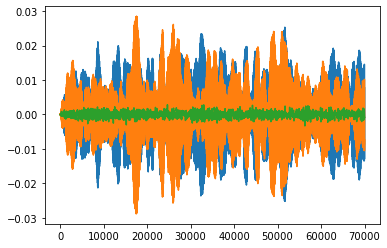

In [32]:
plt.plot(velocities[:,0])

In [39]:
a = [autocorrelation(velocities[20000:,i]) for i in range(4)]
a = np.array(a)


a = np.abs(np.fft.fft(a, axis=1))
a = np.mean(a,axis=0)

In [40]:
f = np.fft.fftfreq(len(a), d=.5/1000)

(0.0, 100.0)

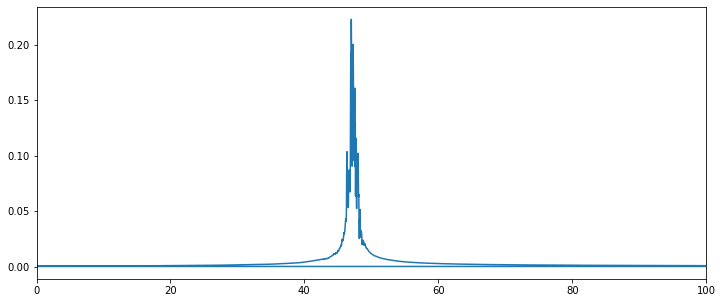

In [41]:
plt.figure(figsize=(12,5))
plt.plot(f, a)
plt.xlim([0,100])